### Test notebook to develop line activity module.
 - Open the NEID file
 - Identify the data extension and the wavelength extension
 - Choose the H-alpha line plot them
 - Continuum normalize the H-alpha order
 - Calculate the equivalent width
 - Figure out how to enter the line list into the config or some other file that
 - From Robertson 2013: IHα =  FHα / (F1+F2) is the sum of the flux in a band of width 1.6 Ang centered on the Hα λ6562.828 Ang line. [−700 km s−1, −300 km s−1] (from the Hα line center) for band 1 and [600 km s−1, 1000 km s−1] for band 2,


In [239]:
# Standard dependencies  (copied from the bias module)
import configparser
import numpy as np
from astropy.io import fits

# Pipeline dependencies
from kpfpipe.logger import start_logger
from kpfpipe.primitives.level0 import KPF0_Primitive
# from kpfpipe.models.level0 import KPF0

# External dependencies
from keckdrpframework.models.action import Action
from keckdrpframework.models.arguments import Arguments
from keckdrpframework.models.processing_context import ProcessingContext

# Above are copied from bias, below are new
from kpfpipe.models.level1 import KPF1
import os
TEST_DIR = os.getenv('KPFPIPE_TEST_DATA')
from astropy.io import fits
from astropy import constants
from matplotlib import pyplot as plt

# import specutils
# from specutils.analysis import equivalent_width
# from specutils import Spectrum1D, SpectralRegion
# from specutils.fitting import fit_generic_continuum
# from specutils.fitting import fit_continuum

from astropy import units as u
from scipy.interpolate import splev, splrep
from scipy import interpolate
%matplotlib inline

In [240]:
plt.rcParams["figure.figsize"] = (18,6)
plt.rcParams.update({'font.size': 20})

In [241]:
# l1 = KPF1()
in_file = '/NEIDdata/TAUCETI_20191217/L2/neidL2_20191217T023129.fits'


# Open L2 data.
print(TEST_DIR + in_file)
with fits.open(TEST_DIR + in_file) as hdul2:
    sci_flux = hdul2['SCIFLUX'].data
    sci_wave = hdul2['SCIWAVE'].data
    cal_wave = hdul2['CALWAVE'].data # Not populated.
    #    head2 = hdul2[0].header
#    head28 = hdul2[8].header
    hdul2.info()    



/data/NEIDdata/TAUCETI_20191217/L2/neidL2_20191217T023129.fits
Filename: /data/NEIDdata/TAUCETI_20191217/L2/neidL2_20191217T023129.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     738   ()      
  1  SCIFLUX       1 ImageHDU        12   (9216, 117)   float64   
  2  SKYFLUX       1 ImageHDU        12   (9216, 117)   float64   
  3  CALFLUX       1 ImageHDU        12   (9216, 117)   float64   
  4  SCIVAR        1 ImageHDU        12   (9216, 117)   float64   
  5  SKYVAR        1 ImageHDU        12   (9216, 117)   float64   
  6  CALVAR        1 ImageHDU        12   (9216, 117)   float64   
  7  SCIWAVE       1 ImageHDU      1976   (9216, 117)   float64   
  8  SKYWAVE       1 ImageHDU      1976   (9216, 117)   float64   
  9  CALWAVE       1 ImageHDU      1976   (9216, 117)   float64   
 10  TELLURIC      1 ImageHDU        10   (9216, 117)   float64   
 11  SKY           1 ImageHDU        10   (9216, 117)   float64   
 12  CCFS     

In [242]:
# Large cosmics are problematic. Replace with nearby median
ord=77 # H-alpha: 656.281 nm
wl = sci_wave[ord,:]
flux = sci_flux[ord,:]
thresh = 3 * np.median(flux)
npix=9216 
for i,item in enumerate(flux):
    if i > 5 and i < npix:
        if item > thresh:
            flux[i] = np.median([flux[i-5],flux[i+5]])
print(thresh)


55480.88664776436


In [261]:
# Calculate the wavelength range needed to extract the continuum and H-alpha sections.
# Delta_lambda / lambda = v/c
# delta_lambda = v/c * lambda
v = 100 * u.km / u.second
c = constants.c.to_value() /1000. * u.km / u.second
Hwav = 6562.828 * u.angstrom
Hwav_nu = 6562.828
Hwindow = 1.6 # * u.angstrom

# delta_lambda = v km s-1 / 3e5 km s-1 
delta_lambda100 = v / c * Hwav  # delta lambda for 100 km/s at H-alpha wavelengths
# 1.6Angstroms around H-alpha should be extracted
print(c)
print(v)
print(delta_lambda100)


299792.458 km / s
100.0 km / s
2.189123783761098 Angstrom


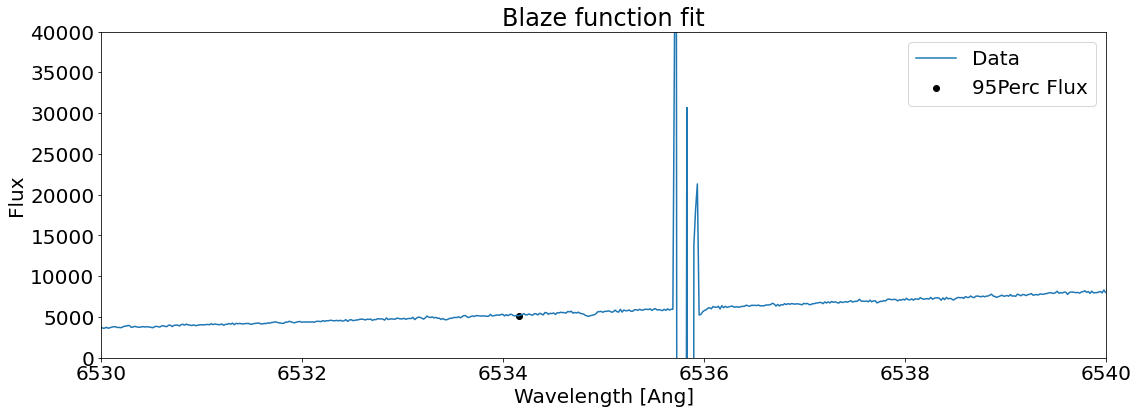

In [201]:
plt.plot(wl,flux,label='Data')    
plt.scatter(wl_values,fl_values,color = 'black',label='95Perc Flux')
plt.title('Blaze function fit')
plt.xlabel('Wavelength [Ang]')
plt.ylabel('Flux')
plt.ylim(0,4e4)
plt.xlim(6530,6540)
plt.legend()
plt.show()

indices: [ 287.  595.  880. 1156. 1496. 1791. 1970. 2393. 2676. 2948. 3236. 3419.
 3796. 3983. 4399. 4507. 4811. 5116. 5435. 5711. 6017. 6305. 6612. 6917.
 7207. 7570. 7839. 8132. 8432. 8724.]
len sci_wave 9216


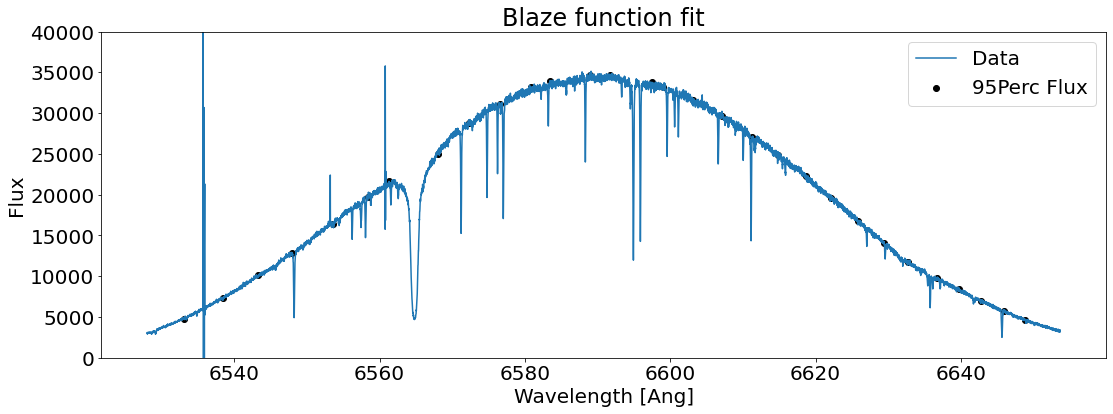

In [233]:
# Use APF-data-analysis to remove the blaze function.
bin=300
indices=[]


# tck = interpolate.splrep(x, y, k=3, s=1000)

#flux = splrep(wl,sci_flux[ord,:],k=3,s=1000) # Smooth the spectrum to remove cosmic rays.

for i in np.arange(len(wl)-bin,step=bin):
    flux_values=[]
    for j in np.arange(i,i+bin,step=1):
        value = flux[j]
        flux_values = np.append(flux_values,value)
        
    flux_in_bin=np.percentile(flux_values,95)#Find 95% tile of flux to avoid cosmics
    absolute_difference_function = lambda list_value : abs(list_value - flux_in_bin)
    flux_in_bin = min(flux_values.tolist(),key=absolute_difference_function)
    index_in_bin = flux_values.tolist().index(flux_in_bin)
    index = i+index_in_bin
    indices = np.append(indices,index)
#    print('index: ',index)
#    print('i= ',i)
print('indices:',indices)
print('len sci_wave',len(wl))
wl_values = []
fl_values = []

for index in indices:
    ind = int(index)
    wl_values = np.append(wl_values,wl[ind])
    fl_values = np.append(fl_values,flux[ind])
    
plt.plot(wl,flux,label='Data')    
plt.scatter(wl_values,fl_values,color = 'black',label='95Perc Flux')
plt.title('Blaze function fit')
plt.xlabel('Wavelength [Ang]')
plt.ylabel('Flux')
plt.ylim(0,4e4)
plt.legend()
plt.show()
    

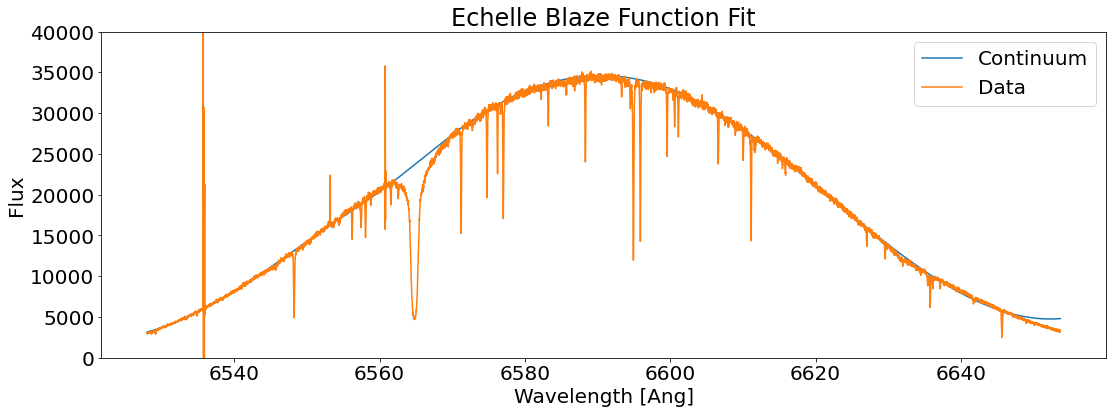

In [234]:
# Calculate the blaze function
spl = splrep(wl_values,fl_values,s=2e6)
flux_fit = splev(wl,spl)
plt.plot(wl,flux_fit,label='Continuum')
plt.plot(wl,flux,label='Data')
plt.xlabel('Wavelength [Ang]')
plt.ylabel('Flux')
plt.title('Echelle Blaze Function Fit')
plt.ylim(0,4e4)
plt.legend()

(0.0, 1.2)

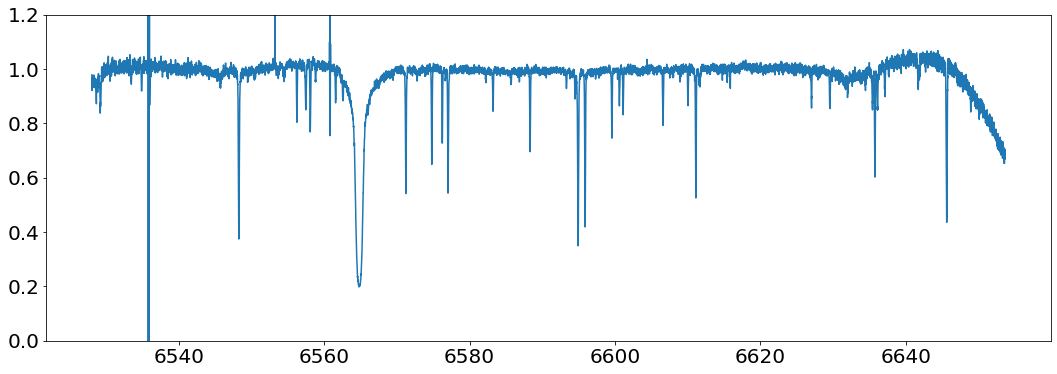

In [235]:
# REmove the blaze function and plot the normalized flux.
norm_sci_flux = flux/flux_fit
plt.plot(wl,norm_sci_flux)
plt.ylim(0.,1.2)

(6535.0, 6595.0)

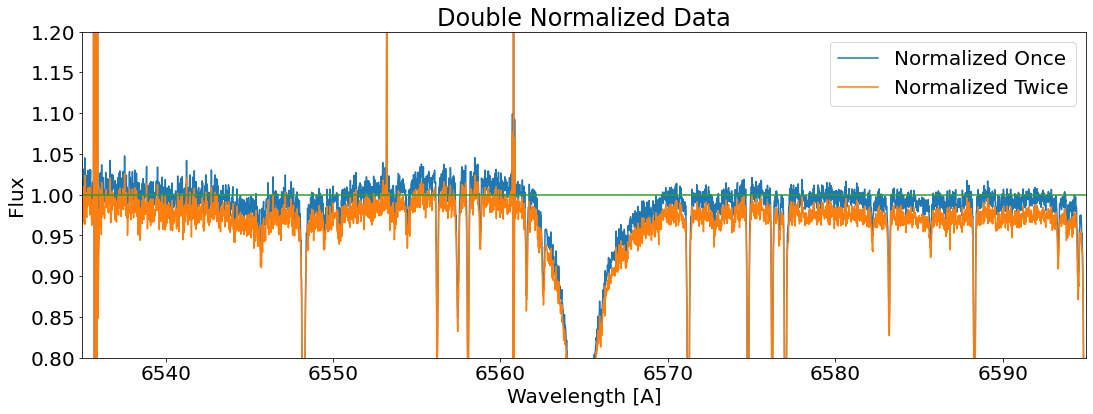

In [287]:
# Refine normalization
flux98 = np.percentile(norm_sci_flux, 92)
norm_sci_flux2 = norm_sci_flux / flux98

plt.plot(wl, norm_sci_flux, label = 'Normalized Once')
plt.plot(wl, norm_sci_flux2, label = 'Normalized Twice')

plt.plot([6530,6650],[1,1])
plt.legend()
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Double Normalized Data')
plt.ylim(0.8,1.2)
plt.xlim(6535,6595)

In [286]:
# Calulate the H-alpha index based on the Robertson (2013) (and references therein) method.
# H_alpha_indices = np.where((sci_wave > (Hwav_nu - Hwindow/2. )) & (sci_wave < (Hwav + Hwindow/2 )))
# H_alpha_indices = sci_wave[sci_wave > (Hwav_nu - Hwindow/2.)]
#Halpha_flux = np.sum(sci_flux[H_alpha-indices])
#Cont1 = np.sum(sci_flux[cont1_indices])
#Cont2 =  np.sum(sci_flux[cont1_indices])
#Hwindow

type(Hwav_nu)

float

In [276]:
#H_alpha_indices.shape
print(H_alpha_indices,Hwav_nu)

(array([], dtype=int64),) 6562.828


In [232]:
# Remove the continuum with the specutils algorithm
wave77 = wave2[ord,:]
spec77 = Spectrum1D(spectral_axis = wave77*u.Angstrom,flux = data2[ord,:] * u.Angstrom)
spec77_cont_fit = fit_generic_continuum(spec77)
spec77_fit = spec77_cont_fit(wave77*u.Angstrom)
plt.plot(spec77_fit)
plt.plot(data2[ord,:])
plt.ylim(0,5e4)
#plt.show()
type(spec77)


NameError: name 'Spectrum1D' is not defined

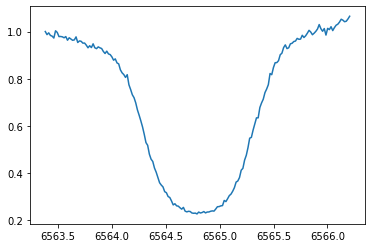

In [5]:
# Try to use the specutils.equivalent_width module to find the EW.
ord = 77
i1  = 2100
i2  =2280
spec = data2[ord,i1:i2]/np.median(data2[ord,i1:i2])
spec /= float(spec[0])
wave = wave2[ord,i1:i2]

plt.plot(wave,spec)
plt.show()


np.random.seed(42)

spectral_axis = np.linspace(11., 1., 200) * u.GHz

spectral_model = models.Gaussian1D(amplitude=5*(2*np.pi*0.8**2)**-0.5*u.Jy, mean=5*u.GHz, stddev=0.8*u.GHz)

flux = spectral_model(spectral_axis)

flux += np.random.normal(0., 0.05, spectral_axis.shape) * u.Jy

uncertainty = StdDevUncertainty(0.2*np.ones(flux.shape)*u.Jy)

noisy_gaussian = Spectrum1D(spectral_axis=spectral_axis, flux=flux, uncertainty=uncertainty)

In [6]:
# Calculate equivalent width
# dx = np.abs(np.diff(spectrum.spectral_axis.bin_edges))
# ew = np.sum((1 - line_flux / cont_flux) * dx)
ha_line_center = 6562.81 *u.Angstrom # Not the line center by looking at the spectrum.
half_width = 1 *u.Angstrom
ew1 = np.sum(1-spec)
#ew1 *= 6564.7 /10**10.
print('ew1=',ew1)

spec4ew = Spectrum1D(spectral_axis = wave*u.Angstrom,flux = spec * u.Angstrom)

ew2=equivalent_width(spec4ew, continuum=1,regions=SpectralRegion(ha_line_center-half_width,ha_line_center+half_width)) 
#equivalent_width(noisy_gaussian_with_continuum, regions=SpectralRegion(7*u.GHz, 3*u.GHz))  
print('ew2=',ew2)

ew1= 53.726563652523524


NameError: name 'Spectrum1D' is not defined

In [ ]:
# print the wavelengths per order

for i,item in enumerate(wave2[:,0]):
#    print(i, wave2[i,0], wave2[i,-1])
#    print(i,min(wave2[i,:]),max(wave2[i,:]))
#    if min(wave2[i,:]) > 6562:# and max(wave2[i,:]) < 6566:
    if max(wave2[i,:]) < 6566:
        print('H-alpha order:',i)


In [7]:
"""
A module for analysis tools focused on determining fluxes of spectral features.
"""

import warnings
from functools import wraps

import numpy as np
from astropy.nddata import StdDevUncertainty, VarianceUncertainty, InverseVariance

from .. import conf
from ..spectra import Spectrum1D
from ..manipulation import extract_region, LinearInterpolatedResampler
from .utils import computation_wrapper
import astropy.units as u
from astropy.stats import mad_std
from astropy.utils.exceptions import AstropyUserWarning


__all__ = ['line_flux', 'equivalent_width', 'is_continuum_below_threshold',
           'warn_continuum_below_threshold']


[docs]
def line_flux(spectrum, regions=None,
              mask_interpolation=LinearInterpolatedResampler):
    """
    Computes the integrated flux in a spectrum or region of a spectrum.

    Applies to the whole spectrum by default, but can be limited to a specific
    feature (like a spectral line) if a region is given.

    Parameters
    ----------
    spectrum : Spectrum1D
        The spectrum object over which the summed flux will be calculated.

    regions : `~specutils.SpectralRegion` or list of `~specutils.SpectralRegion`
        Region within the spectrum to calculate the gaussian sigma width. If
        regions is `None`, computation is performed over entire spectrum.

    mask_interpolation : ``None`` or `~specutils.manipulation.LinearInterpolatedResampler`
        Interpolator class used to fill up the gaps in the spectrum's flux
        array, when the spectrum mask is not None. If set to ``None``, the
        masked spectral bins are excised from the data without interpolation
        and the bin edges of the adjacent bins are extended to fill the gap.

    Returns
    -------
    flux : `~astropy.units.Quantity`
        Flux in the provided spectrum (or regions). Unit isthe ``spectrum``'s'
        ``flux`` unit times ``spectral_axis`` unit.

    Notes
    -----
    While the flux can be computed on any spectrum or region, it should be
    continuum-subtracted to compute actual line fluxes.
    """
    return computation_wrapper(_compute_line_flux, spectrum, regions,
                               mask_interpolation=mask_interpolation)



[docs]
def equivalent_width(spectrum, continuum=1, regions=None,
                     mask_interpolation=LinearInterpolatedResampler):
    """
    Computes the equivalent width of a region of the spectrum.

    Applies to the whole spectrum by default, but can be limited to a specific
    feature (like a spectral line) if a region is given.

    Parameters
    ----------
    spectrum : Spectrum1D
        The spectrum object overwhich the equivalent width will be calculated.

    regions: `~specutils.SpectralRegion` or list of `~specutils.SpectralRegion`
        Region within the spectrum to calculate the equivalent width. If
        regions is `None`, computation is performed over entire spectrum.

    continuum : ``1`` or `~astropy.units.Quantity`, optional
        Value to assume is the continuum level.  For the special value ``1``
        (without units), ``1`` in whatever the units of the ``spectrum.flux``
        will be assumed, otherwise units are required and must be the same as
        the ``spectrum.flux``.

    mask_interpolation : ``None`` or `~specutils.manipulation.LinearInterpolatedResampler`
        Interpolator class used to fill up the gaps in the spectrum's flux
        array after an excise operation to ensure the mask shape can always be
        applied when the spectrum mask is not None. If set to ``None``, the
        masked spectral bins are excised from the data without interpolation
        and the bin edges of the adjacent bins are extended to fill the gap.

    Returns
    -------
    ew : `~astropy.units.Quantity`
        Equivalent width calculation, in the same units as the ``spectrum``'s
        ``spectral_axis``.

    Notes
    -----
    To do a standard equivalent width measurement, the ``spectrum`` should be
    continuum-normalized to whatever ``continuum`` is before this function is
    called.

    """

    kwargs = dict(continuum=continuum)
    return computation_wrapper(_compute_equivalent_width, spectrum, regions,
                               mask_interpolation=mask_interpolation, **kwargs)



def _compute_line_flux(spectrum, regions=None,
                       mask_interpolation=LinearInterpolatedResampler):

    if regions is not None:
        calc_spectrum = extract_region(spectrum, regions)
    else:
        calc_spectrum = spectrum

    # Account for the existence of a mask.
    if hasattr(calc_spectrum, 'mask') and calc_spectrum.mask is not None:
        mask = calc_spectrum.mask
        new_spec = Spectrum1D(flux=calc_spectrum.flux[~mask],
                              spectral_axis=calc_spectrum.spectral_axis[~mask])

        if mask_interpolation is None:
            return _compute_line_flux(new_spec)
        else:
            interpolator = mask_interpolation(extrapolation_treatment='zero_fill')
            sp = interpolator(new_spec, calc_spectrum.spectral_axis)
            flux = sp.flux
    else:
        flux = calc_spectrum.flux

    dx = np.abs(np.diff(calc_spectrum.spectral_axis.bin_edges))
    line_flux = np.sum(flux * dx)

    line_flux.uncertainty = None

    if calc_spectrum.uncertainty is not None:
        # Can't handle masks via interpolation here, since interpolators
        # only work with the flux array.
        if isinstance(calc_spectrum.uncertainty, StdDevUncertainty):
            variance_q = calc_spectrum.uncertainty.quantity ** 2
        elif isinstance(calc_spectrum.uncertainty, VarianceUncertainty):
            variance_q = calc_spectrum.uncertainty.quantity
        elif isinstance(calc_spectrum.uncertainty, InverseVariance):
            variance_q = 1/calc_spectrum.uncertainty.quantity
        else:
            warnings.warn(f"Uncertainty type "
                          f"'{calc_spectrum.uncertainty.uncertainty_type}' "
                          f"was not recognized by line_flux. Proceeding "
                          f"without uncertainty in result.",
                          AstropyUserWarning)
            variance_q = None

        if variance_q is not None:
            line_flux.uncertainty = np.sqrt(
                np.sum(variance_q * dx**2))

    # TODO: we may want to consider converting to erg / cm^2 / sec by default
    return line_flux


def _compute_equivalent_width(spectrum, continuum=1, regions=None,
                              mask_interpolation=LinearInterpolatedResampler):
    if regions is not None:
        spectrum = extract_region(spectrum, regions)

    # Account for the existence of a mask.
    if hasattr(spectrum, 'mask') and spectrum.mask is not None:
        mask = spectrum.mask
        spectrum = Spectrum1D(
            flux=spectrum.flux[~mask],
            spectral_axis=spectrum.spectral_axis[~mask])

    # Calculate the continuum flux value
    continuum = u.Quantity(continuum, unit=spectrum.flux.unit)

    # If continuum is provided as a single scalar/quantity value, create an
    # array the same size as the processed spectrum. Otherwise, assume that the
    # continuum was provided as an array and use as-is.
    if continuum.size == 1:
        continuum = continuum * np.ones(spectrum.flux.size)

    cont_spec = Spectrum1D(flux=continuum,
                           spectral_axis=spectrum.spectral_axis)
    cont_flux = _compute_line_flux(cont_spec,
                                   mask_interpolation=mask_interpolation)
    line_flux = _compute_line_flux(spectrum,
                                   mask_interpolation=mask_interpolation)

    # Calculate equivalent width
    dx = np.abs(np.diff(spectrum.spectral_axis.bin_edges))
    ew = np.sum((1 - line_flux / cont_flux) * dx)

    return ew.to(spectrum.spectral_axis.unit)


[docs]
def is_continuum_below_threshold(spectrum, threshold=0.01):
    """
    Determine if the baseline of this spectrum is less than a threshold.
    I.e., an estimate of whether or not the continuum has been subtracted.

    If ``threshold`` is an `~astropy.units.Quantity` with flux units, this
    directly compares the median of the spectrum to the threshold.
    of the flux to the threshold.

    If the threshold is a float or dimensionless quantity then the spectrum's uncertainty will be
    used or an estimate of the uncertainty. If the uncertainty is present then the
    threshold is compared to the median of the flux divided by the
    uncertainty.  If the uncertainty is not present then the threshold
    is compared to the median of the flux divided by the
    `~astropy.stats.mad_std`.

    Parameters
    ----------
    spectrum : `~specutils.spectra.spectrum1d.Spectrum1D`
        The spectrum object over which the width will be calculated.

    threshold: float or `~astropy.units.Quantity`
        The tolerance on the quantification to confirm the continuum is
        near zero.

    Returns
    -------
    is_continuum_below_threshold: bool
        Return True if the continuum of the spectrum is below the threshold, False otherwise.

    """

    flux = spectrum.flux
    uncertainty = spectrum.uncertainty if hasattr(spectrum, 'uncertainty') else None

    # Apply the mask if it exists.
    if hasattr(spectrum, 'mask') and spectrum.mask is not None:
        flux = flux[~spectrum.mask]
        uncertainty = uncertainty[~spectrum.mask] if uncertainty else uncertainty

    # If the threshold has units then the assumption is that we want
    # to compare the median of the flux regardless of the
    # existence of the uncertainty.
    if hasattr(threshold, 'unit') and not threshold.unit == u.dimensionless_unscaled:
        return np.median(flux) < threshold

    # If threshold does not have a unit, ie it is not a quantity, then
    # we are going to calculate based on the S/N if the uncertainty
    # exists.
    if uncertainty and uncertainty.uncertainty_type != 'std':
        return np.median(flux / uncertainty.quantity) < threshold
    else:
        return np.median(flux) / mad_std(flux) < threshold



[docs]
def warn_continuum_below_threshold(threshold=0.01):
    """
    Decorator for methods that should warn if the baseline
    of the spectrum does not appear to be below a threshold.

    The ``check`` parameter is based on the
    `astropy configuration system <http://docs.astropy.org/en/stable/config/#adding-new-configuration-items>`_.
    Examples are on that page to show how to turn off this type of warning checking.
    """
    def actual_decorator(function):
        @wraps(function)
        def wrapper(*args, **kwargs):
            if conf.do_continuum_function_check:
                spectrum = args[0]
                if not is_continuum_below_threshold(spectrum, threshold):
                    if hasattr(threshold, 'unit'):
                        levelorsnr = 'value'
                    else:
                        levelorsnr = 'signal-to-noise'

                    message = "Spectrum is not below the threshold {} {}. ".format(levelorsnr, threshold)
                    message += "This may indicate you have not continuum subtracted this spectrum (or that you have but it has high SNR features).\n\n"
                    message += ("""If you want to suppress this warning either type """
                                """'specutils.conf.do_continuum_function_check = False' or """
                                """see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items """
                                """for other ways to configure the warning.""")

                    warnings.warn(message, AstropyUserWarning)
            result = function(*args, **kwargs)
            return result
        return wrapper
    return actual_decorator

ValueError: attempted relative import beyond top-level package